### 사전 훈련된 모델을 사용하는 두 가지 방법 : 

1. 특성 추출(feature extraction)

2. 미세 조정(fine tuning)

### keras에서 사전 훈련된 모델들을 제공해준다. (keras.applications 모듈 참조.)

그 중 제공되는 이미지 분류 모델은 다음과 같다. (모두 imageNet으로 훈련)

Xception

Inception V3

ResNet50

VGG16 / VGG19

MobileNet

### 우린 여기서 VGG16을 활용해서 튜토리얼을 진행한다.

In [2]:
from keras.applications import VGG16

In [4]:
conv_base = VGG16(weights="imagenet", 
                include_top=False, # fully connected layer를 사용할 것이냐 말것이냐?
                input_shape=(150,150,3))

58892288/58889256 [==============================] - 6s 0us/step


In [5]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [7]:
from keras import layers
from keras import models
# Data Preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
# Draw Image / plot
import matplotlib.pyplot as plt
import numpy as np
import os

In [12]:
dataset_dir = "../keras_dataset/dogs_cats_small/"
train_dir = dataset_dir + "train"
valid_dir = dataset_dir + "validation"
test_dir = dataset_dir + "test"

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150,150),
                                            batch_size=batch_size,
                                            class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i+1)*batch_size] = features_batch
        labels[i * batch_size : (i+1) * batch_size] = labels_batch
        i += 1
        if i* batch_size >= sample_count:
            break
        
    return features, labels
    

In [13]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(valid_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [19]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [20]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))

In [22]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss="binary_crossentropy",
             metrics=['acc'])

In [23]:
train_features.shape

(2000, 8192)

In [24]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels)
                   )

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 814us/step - loss: 0.5874 - acc: 0.6780 - val_loss: 0.4454 - val_acc: 0.8530
Epoch 2/30
2000/2000 [==============================] - 1s 360us/step - loss: 0.4411 - acc: 0.8025 - val_loss: 0.3779 - val_acc: 0.8540
Epoch 3/30
2000/2000 [==============================] - 1s 350us/step - loss: 0.3608 - acc: 0.8525 - val_loss: 0.3253 - val_acc: 0.8900
Epoch 4/30
2000/2000 [==============================] - 1s 348us/step - loss: 0.3186 - acc: 0.8695 - val_loss: 0.3007 - val_acc: 0.8970
Epoch 5/30
2000/2000 [==============================] - 1s 334us/step - loss: 0.2903 - acc: 0.8910 - val_loss: 0.2826 - val_acc: 0.8970
Epoch 6/30
2000/2000 [==============================] - 1s 342us/step - loss: 0.2718 - acc: 0.8920 - val_loss: 0.2704 - val_acc: 0.8980
Epoch 7/30
2000/2000 [==============================] - 1s 327us/step - loss: 0.2529 - acc: 0.8985 - val_loss: 0.2622 - val_acc: 0.8960


### Draw plot

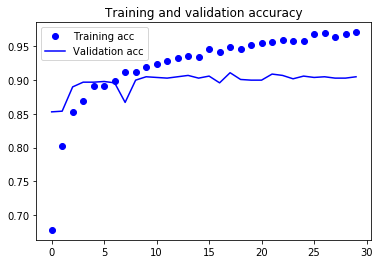

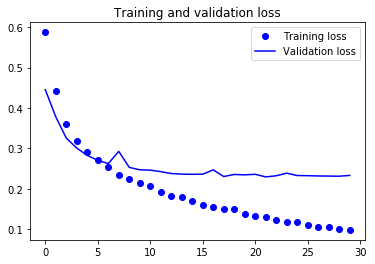

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()